Set up for interacting with LIST API

In [1]:
import os
import pandas as pd
import pathlib
import requests
from dotenv import load_dotenv

script_grandparent_path = os.path.abspath('..')
dotenv_path = pathlib.Path(script_grandparent_path, ".env")
load_dotenv(dotenv_path)

LIST_API_KEY = os.getenv("LIST_API_KEY")

list_url = 'https://m4-2dcc.vmhost.psu.edu/list'
api_url = list_url + '/api/v2/'

headers = {
    'Content-Type': 'application/json',
    'X-API-Key': LIST_API_KEY
}

query = {'instrumentId': 'MBE2'}

Defining function to get a list of samples. This particular query is to get all samples that were made in MBE2 and have AFM data.

In [2]:
def getSampleList(query=query,headers=headers):
    response = requests.post(api_url+'samples/search', json=query, headers=headers)

    all_samples = response.json()
    dir(response)
    print(response.json())
    keys = ['id', 'sampleLabel', 'creationDate', 'materials', 'techniqueId', 'userId']
    data = all_samples['data']
    df = pd.DataFrame({k: [x[k] for x in data] for k in keys})
    print(df)
    return df

In [3]:
import os

query = {'instrumentId': 'MBE2', 'withCharacterization': 'AFM'}
response = requests.post(api_url+'samples/search', json=query, headers=headers)
all_samples = response.json()['data']
print(f'retrieved {len(all_samples)} MBE2 records with AFM data from LiST')

retrieved 428 MBE2 records with AFM data from LiST


In [4]:
keys = ['id', 'sampleLabel', 'creationDate', 'materials', 'techniqueId', 'userId']
data = all_samples
df = pd.DataFrame({k: [x[k] for x in data] for k in keys})
df

,id,sampleLabel,creationDate,materials,techniqueId,userId
0,9,MBE2-181112B-MH,2018-11-12T00:00:00,"[Pt, Se]",Hybrid MBE,mxh752
1,10,MBE2-181114A-MH,2018-11-14T00:00:00,"[Pt, Se]",Hybrid MBE,mxh752
2,19,MBE2-181219B-MH,2018-12-19T00:00:00,[Te],Hybrid MBE,mxh752
3,20,MBE2-181220A-MH,2018-12-20T00:00:00,[Pt],Hybrid MBE,mxh752
4,56,MBE2-181220D-MH,2018-12-20T00:00:00,[PtSe2],Hybrid MBE,mxh752
...,...,...,...,...,...,...
423,16394,MBE2-230209D-MY,2023-02-09T00:00:00,[GaAs],Hybrid MBE,mqy5252
424,16444,MBE2-230216A-MY,2023-02-16T00:00:00,[GaAs],Hybrid MBE,mqy5252
425,16445,MBE2-230216B-MY,2023-02-16T00:00:00,[GaAs],Hybrid MBE,mqy5252
426,16446,MBE2-230216C-MY,2023-02-16T00:00:00,[GaAs],Hybrid MBE,mqy5252


In [5]:
id = 16394
response = requests.get(api_url+f'samples/{id}/activities', headers=headers)
response.json()

[{'sampleId': 16394,
  'sample': {'sampleLabel': 'MBE2-230209D-MY',
   'subSamples': [],
   'transfered': False,
   'finalized': False,
   'shipped': False,
   'useAsSubstrate': False,
   'materialIds': [],
   'materials': [],
   'notes': [],
   'files': [],
   'status': 'N'},
  'pieces': [],
  'technique': 'Hybrid MBE',
  'instrument': 'MBE2',
  'recipeTemplate': 'Hybrid MBE',
  'recipe': {'templateName': 'Hybrid MBE',
   'templateHash': '1ba4f78db9d5298e657f43d2d11b78a1167a7486',
   'runtimeChangedManualy': True,
   'calculatedRuntime': 0.0,
   'groups': [{'name': 'Recipe',
     'symbol': 'recipe',
     'rowType': 'F',
     'scrolling': True,
     'recipeID': 0,
     'allowSeveral': False,
     'copyLastRow': False,
     'comments': 'off',
     'commentTypeEnum': {'id': 'off', 'label': 'Off'},
     'columns': [{'symbol': 'step',
       'name': 'Step',
       'type': 'S',
       'precision': 0,
       'sourceType': 'M',
       'visibility': 'A',
       'updateVisibilities': False,
   

In [6]:
target = "MBE2-230209D-MY"

# fetch sample ids
id = [it['id'] for it in all_samples if it['sampleLabel'] in target]
if len(id) != 1:
    raise ValueError(f'Expected exactly one matching sample, found {len(id)}')
# fetch activities
response = requests.get(api_url+f'samples/{id[0]}/activities', headers=headers)
if not response.ok:
    raise RuntimeError(f'Failed LiST query for sample {id}')
activities = response.json()
afm_activities = [it for it in activities if 'AFM' in it['instrument']]

In [7]:
# record spm files in each AFM activity
SPMs = []
for afm in afm_activities:
    activity_id = afm['id']
    for f in afm['files']:
        for g in f['files']:
            if g['filetype'] == 'spm':
                SPMs.append(dict(activity_id=activity_id, file_id=g['id'], filename=g['filename']))
print(SPMs)

[{'activity_id': 32041, 'file_id': 226419, 'filename': '230209D-5by5um-512pixels-2.5nN-10um-newtip.spm'}, {'activity_id': 32041, 'file_id': 226420, 'filename': '230209D-5by5um-512pixels-2.5nN-10um.spm'}]


In [8]:
# fetch the SPM from LIST
it = SPMs[0]
print(f"retrieving {it['filename']} from the LiST server...")
response = requests.get(api_url+f"sample-activities/{it['activity_id']}/files/{it['file_id']}", headers=headers)
if not response.ok:
    raise RuntimeError(f"Could not retrieve {it['filename']} from LiST")
with open(it['filename'], "wb") as fid:
    fid.write(response.content)

retrieving 230209D-5by5um-512pixels-2.5nN-10um-newtip.spm from the LiST server...


In [9]:
import mcda.afm as afm
import matplotlib.pyplot as plt
import numpy as np
filename = it['filename']
scan, topo = afm.importBrukerAFMData(filename)

Shows uncorrected AFM scan directly from LIST data.

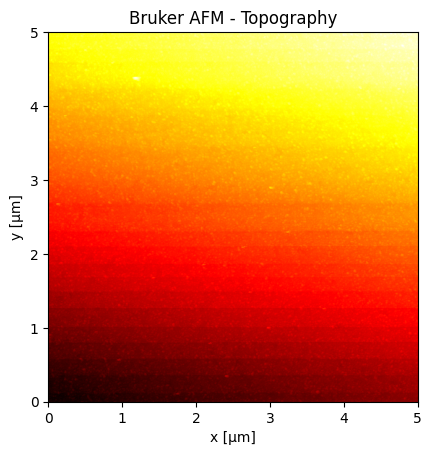

In [10]:
afm.showHeightSensor(topo)

Does a simple plane correct and displays the AFM image with a color bar. NOTE: The axis on this image are incorrect, it is showing currently by pixel size. 

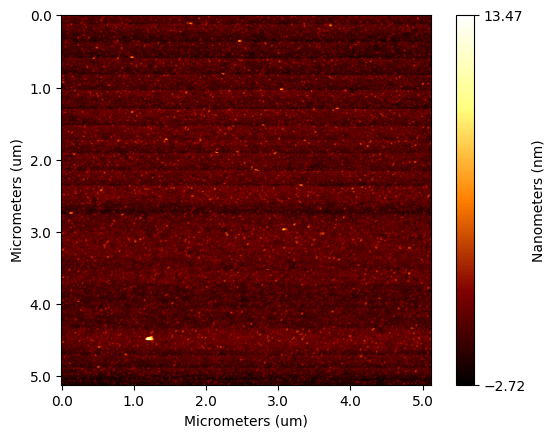

In [11]:
scanSize = 5
scanSizeLabel = 'Micrometers (um)'
afm.showHeightSensorCorrected(topo,scanSize,scanSizeLabel)

Example of getting transport/PPMS data down from LIST and processing it.

In [12]:
query = {'instrumentId': 'MBE1', 'charInstrument': 'TRP4'}
response = requests.post(api_url+'samples/search', json=query, headers=headers)
all_samples = response.json()['data']
print(f'retrieved {len(all_samples)} MBE1 records with Transport data from LiST')

retrieved 2032 MBE1 records with Transport data from LiST


In [13]:
keys = ['id', 'sampleLabel', 'creationDate', 'materials', 'techniqueId', 'userId']
data = all_samples
df = pd.DataFrame({k: [x[k] for x in data] for k in keys})
df

,id,sampleLabel,creationDate,materials,techniqueId,userId
0,2679,MBE1-180309A-AR,2018-03-09T00:00:00,[Bi2Te3],MBE,arr19
1,2487,MBE1-180312A-AR,2018-03-12T00:00:00,[Sb2Te3],MBE,arr19
2,2488,MBE1-180314A-AR,2018-03-14T00:00:00,[],MBE,arr19
3,917,MBE1-180317A-TP,2018-03-17T00:00:00,"[(Bi,Sb)2Te3]",MBE,tsp136
4,930,MBE1-180318A-TP,2018-03-18T00:00:00,"[(Bi,Sb)2Te3]",MBE,tsp136
...,...,...,...,...,...,...
2027,17567,MBE1-230607B-HY,2023-06-07T00:00:00,"[FeTe, FeTe, Bi2Te3]",MBE,hxy5212
2028,17597,MBE1-230608A-YO,2023-06-08T00:00:00,"[(Bi,Sb)2Te3, Bi,Sb]",MBE,ypo5017
2029,17602,MBE1-230608B-MS,2023-06-08T00:00:00,[CoFeSe],MBE,mzs1148
2030,17603,MBE1-230609A-YO,2023-06-09T00:00:00,"[(Bi,Sb)2Te3]",MBE,ypo5017


In [14]:
id = 'MBE1-230327A-MS'
response = requests.get(api_url+f'samples/{id}/activities', headers=headers)
activities = response.json()
trp_activities = [it for it in activities if 'TRP' in it['instrument']]

In [15]:
trps = []
for trp in trp_activities:
    activity_id = trp['id']
    for f in trp['files']:
        for g in f['files']:
            if g['filetype'] == 'dat':
                trps.append(dict(activity_id=activity_id, file_id=g['id'], filename=g['filename']))
print(trps)

[{'activity_id': 32819, 'file_id': 233483, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_50K.dat'}, {'activity_id': 32819, 'file_id': 233484, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_400K_slow_2.dat'}, {'activity_id': 32819, 'file_id': 233486, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_400K_slow.dat'}, {'activity_id': 32819, 'file_id': 233488, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_400K_quick.dat'}, {'activity_id': 32819, 'file_id': 233490, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_375K_slow.dat'}, {'activity_id': 32819, 'file_id': 233492, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_375K.dat'}, {'activity_id': 32819, 'file_id': 233494, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_350K_2.dat'}, {'activity_id': 32819, 'file_id': 233495, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_350K.dat'}, {'activity_id': 32819, 'file_id': 233498, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_300K.dat'}, {'activity_id': 32819, 'file_id': 233500, 'filename': 'TRP4_MBE1-230327A-MS_RvsH_2K.dat'}, {'activity_id': 32819, 'file_id': 233503, 'file

In [16]:
it = trps[0]
print(f"retrieving {it['filename']} from the LiST server...")
response = requests.get(api_url+f"sample-activities/{it['activity_id']}/files/{it['file_id']}", headers=headers)
if not response.ok:
    raise RuntimeError(f"Could not retrieve {it['filename']} from LiST")
with open(it['filename'], "wb") as fid:
    fid.write(response.content)

retrieving TRP4_MBE1-230327A-MS_RvsH_50K.dat from the LiST server...


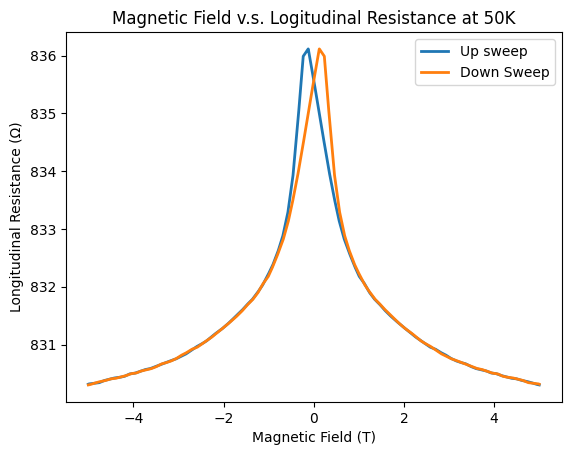

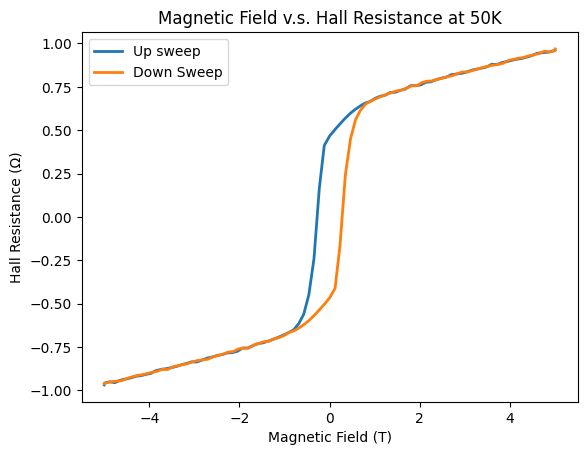

In [17]:
import mcda.ppms as ppms

filename = it['filename']
save_path = "data/example outputs/ppms/"
min_field = -5
temperature, magnetic_field_df, bridge1_resistance_df, bridge2_resistance_df, = ppms.RvsH_dat_file_import(filename)
fielddown, resistancedown, Hall_resistancedown, fieldup, resistanceup, Hall_resistanceup, = ppms.get_RvsH_down_and_up(magnetic_field_df, bridge1_resistance_df, bridge2_resistance_df, min_field)
FixedField, RxxAvg, FinalRxx, RxyAvg, FinalRxy = ppms.interpolate_and_symmetrize(fielddown,resistancedown,Hall_resistancedown,fieldup,resistanceup,Hall_resistanceup)
ppms.Field_vs_Rxx_down_and_up(FixedField,RxxAvg,temperature)
ppms.Field_vs_Rxy_down_and_up(FixedField, RxyAvg, temperature)